# Final  Project 
# SOURCE : data.ny.gov
#  Oluwaseyi Durosinmi-Etti 

# Data : This Data showcases information about MTA Subway Hourly Ridership



In [1]:
import requests
import pandas as pd
import json
from urllib import request
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
from sklearn.preprocessing import LabelEncoder
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
###We are loading the the Json api from datagov which has information about MTA subway hourly ridership from to 2020-2024
##we only want to get data from 2021 to 2024. Note : This data is static has has about 3000000 rows.
##issues that arosed:because this data was static alot of our insight might be skewed and also when 
##it came to the logistic regression we have limit data to make a prediction.


MTAdailyurl ="https://data.ny.gov/resource/wujg-7c2s.json?$limit=3000000"


In [3]:
mtadailyresponse =requests.get(MTAdailyurl)

In [4]:
if mtadailyresponse.status_code == 200:
    data = mtadailyresponse.json()
    print(data[100])  # Print first 5 records 
else:
    print(f"Error: {mtadailyresponse.status_code}")

{'transit_timestamp': '2022-05-16T01:00:00.000', 'transit_mode': 'subway', 'station_complex_id': '9', 'station_complex': '57 St-7 Av (N,Q,R,W)', 'borough': 'Manhattan', 'payment_method': 'metrocard', 'fare_class_category': 'Metrocard - Unlimited 30-Day', 'ridership': '16.0', 'transfers': '0.0', 'latitude': '40.764664', 'longitude': '-73.98066', 'georeference': {'type': 'Point', 'coordinates': [-73.98066, 40.764664]}, ':@computed_region_kjdx_g34t': '2095', ':@computed_region_yamh_8v7k': '749', ':@computed_region_wbg7_3whc': '742'}


In [5]:
Daily_ride =pd.DataFrame(data)

In [6]:
Daily_ride.head(1)

,transit_timestamp,transit_mode,station_complex_id,station_complex,borough,payment_method,fare_class_category,ridership,transfers,latitude,longitude,georeference,:@computed_region_kjdx_g34t,:@computed_region_yamh_8v7k,:@computed_region_wbg7_3whc
0,2022-05-16T21:00:00.000,subway,617,"Atlantic Av-Barclays Ctr (B,D,N,Q,R,2,3,4,5)",Brooklyn,metrocard,Metrocard - Full Fare,239.0,3.0,40.68446,-73.97689,"{'type': 'Point', 'coordinates': [-73.97689, 4...",2090,894,895


In [7]:
Daily_ride["transit_timestamp"] = pd.to_datetime(Daily_ride["transit_timestamp"]).dt.strftime('%Y-%m-%d')

In [8]:
Daily_ride['latitude']= pd.to_numeric(Daily_ride['latitude'])

In [9]:
Daily_ride['longitude']= pd.to_numeric(Daily_ride['longitude'])

In [10]:
Daily_ride.head(1)

,transit_timestamp,transit_mode,station_complex_id,station_complex,borough,payment_method,fare_class_category,ridership,transfers,latitude,longitude,georeference,:@computed_region_kjdx_g34t,:@computed_region_yamh_8v7k,:@computed_region_wbg7_3whc
0,2022-05-16,subway,617,"Atlantic Av-Barclays Ctr (B,D,N,Q,R,2,3,4,5)",Brooklyn,metrocard,Metrocard - Full Fare,239.0,3.0,40.68446,-73.97689,"{'type': 'Point', 'coordinates': [-73.97689, 4...",2090,894,895


In [11]:
Daily_ride.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000000 entries, 0 to 2999999
Data columns (total 15 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   transit_timestamp            object 
 1   transit_mode                 object 
 2   station_complex_id           object 
 3   station_complex              object 
 4   borough                      object 
 5   payment_method               object 
 6   fare_class_category          object 
 7   ridership                    object 
 8   transfers                    object 
 9   latitude                     float64
 10  longitude                    float64
 11  georeference                 object 
 12  :@computed_region_kjdx_g34t  object 
 13  :@computed_region_yamh_8v7k  object 
 14  :@computed_region_wbg7_3whc  object 
dtypes: float64(2), object(13)
memory usage: 343.3+ MB


In [12]:
Daily_ride.head(1)

,transit_timestamp,transit_mode,station_complex_id,station_complex,borough,payment_method,fare_class_category,ridership,transfers,latitude,longitude,georeference,:@computed_region_kjdx_g34t,:@computed_region_yamh_8v7k,:@computed_region_wbg7_3whc
0,2022-05-16,subway,617,"Atlantic Av-Barclays Ctr (B,D,N,Q,R,2,3,4,5)",Brooklyn,metrocard,Metrocard - Full Fare,239.0,3.0,40.68446,-73.97689,"{'type': 'Point', 'coordinates': [-73.97689, 4...",2090,894,895


In [13]:
import requests
import pandas as pd
from datetime import datetime

# Map boroughs to coordinates (latitude, longitude)
borough_coordinates = {
    "Manhattan": (40.7831, -73.9712),
    "Brooklyn": (40.6782, -73.9442),
    "Queens": (40.7282, -73.7949),
    "Bronx": (40.8448, -73.8648),
    "Staten Island": (40.5795, -74.1502)
}

# Fetch weather data for given boroughs and year range
def get_weather_data_for_boroughs(boroughs, start_year=2020, end_year=2024):
    all_data = []
    weather_url = "https://archive-api.open-meteo.com/v1/archive"

    for borough in boroughs:
        latitude, longitude = borough_coordinates[borough]
        
        for year in range(start_year, end_year + 1):
            params = {
                "latitude": latitude,
                "longitude": longitude,
                "start_date": f"{year}-01-01",
                "end_date": f"{year}-12-31",
                "daily": "precipitation_sum",
                "timezone": "auto"    
            }

            response = requests.get(weather_url, params=params)
            if response.status_code == 200:
                data = response.json()
                dates = data["daily"]["time"]
                precipitation = data["daily"]["precipitation_sum"]

                for date, precip in zip(dates, precipitation):
                    all_data.append({
                        "date": date,
                        "borough": borough,
                        "rain_status": "Rainy" if precip > 0 else "Not Raining"
                    })
            else:
                print(f"Failed to fetch data for {borough} in {year}")
                continue

    return pd.DataFrame(all_data)

# Example usage
boroughs = ["Manhattan", "Brooklyn", "Queens", "Bronx", "Staten Island"]
weather_df = get_weather_data_for_boroughs(boroughs)
print(weather_df.head())


         date    borough  rain_status
0  2020-01-01  Manhattan  Not Raining
1  2020-01-02  Manhattan  Not Raining
2  2020-01-03  Manhattan        Rainy
3  2020-01-04  Manhattan        Rainy
4  2020-01-05  Manhattan        Rainy


In [14]:
weather_df.head(1)

,date,borough,rain_status
0,2020-01-01,Manhattan,Not Raining


In [15]:
Daily_ride_with_rainstatus =pd.merge(Daily_ride,weather_df,left_on =['transit_timestamp','borough'],right_on =['date','borough'],how ='left')

In [16]:
Daily_ride_with_rainstatus.head(1)

,transit_timestamp,transit_mode,station_complex_id,station_complex,borough,payment_method,fare_class_category,ridership,transfers,latitude,longitude,georeference,:@computed_region_kjdx_g34t,:@computed_region_yamh_8v7k,:@computed_region_wbg7_3whc,date,rain_status
0,2022-05-16,subway,617,"Atlantic Av-Barclays Ctr (B,D,N,Q,R,2,3,4,5)",Brooklyn,metrocard,Metrocard - Full Fare,239.0,3.0,40.68446,-73.97689,"{'type': 'Point', 'coordinates': [-73.97689, 4...",2090,894,895,2022-05-16,Rainy


In [17]:
Daily_ride_with_rainstatus= Daily_ride_with_rainstatus[['transit_timestamp','station_complex_id','station_complex','borough',
                                                       'payment_method','fare_class_category','ridership','transfers','latitude'
                                                       ,'longitude','rain_status']]

In [18]:
###now we are going to do some categorical analysis,

Daily_ride_with_rainstatus['rain_status'] =Daily_ride_with_rainstatus['rain_status'].astype('category')

In [19]:
def convert_numeric_columns(df):
  
    for col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='ignore')  # Ignores non-numeric columns
    return df

#Apply function to your DataFrame
Daily_ride_with_rainstatus = convert_numeric_columns(Daily_ride_with_rainstatus)


In [20]:
rideshipbydates =Daily_ride_with_rainstatus.groupby('transit_timestamp')['ridership'].mean()

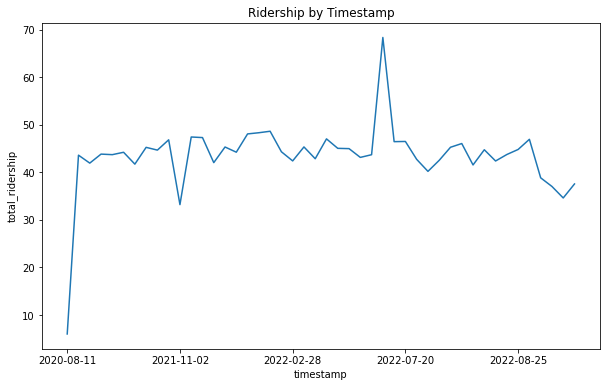

In [21]:
rideshipbydates.plot(kind='line',figsize =(10,6))
plt.title('Ridership by Timestamp')
plt.xlabel('timestamp')
plt.ylabel('total_ridership')
plt.show()

In [22]:
"""
This time series graph illustrates subway ridership trends over time, 
identifying patterns such as seasonal fluctuations and changes during specific events. 
The analysis reveals a decline in ridership on days closer to holiday periods and weekends, 
suggesting a consistent trend in travel behavior.


"""

'\nThis time series graph illustrates subway ridership trends over time, \nidentifying patterns such as seasonal fluctuations and changes during specific events. \nThe analysis reveals a decline in ridership on days closer to holiday periods and weekends, \nsuggesting a consistent trend in travel behavior.\n\n\n'

In [23]:
ridershipbydates_borough =Daily_ride_with_rainstatus.groupby(['borough'])['ridership'].mean()

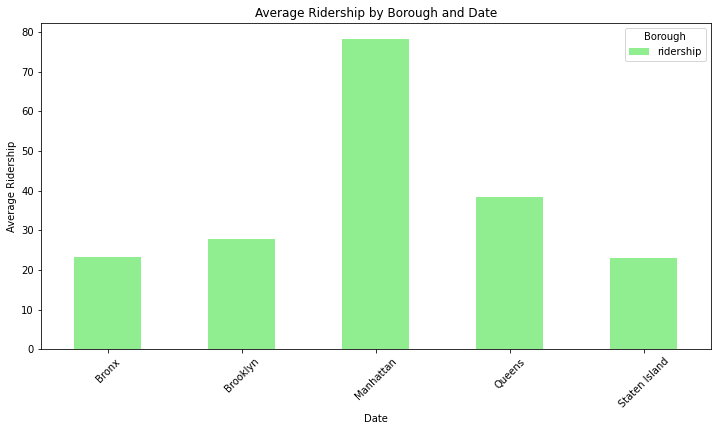

In [24]:
# Convert to DataFrame
ridershipbydates_borough  # Make boroughs separate columns

# Now plot
ridershipbydates_borough.plot(kind='bar', figsize=(12, 6), color='lightgreen')

plt.title('Average Ridership by Borough and Date')
plt.xlabel('Date')
plt.ylabel('Average Ridership')
plt.xticks(rotation=45)
plt.legend(title='Borough')
plt.show()

In [25]:
ridership_sum = Daily_ride_with_rainstatus.groupby('borough')['ridership'].sum()
print(ridership_sum)


borough
Bronx            11238362.0
Brooklyn         30093288.0
Manhattan        69873671.0
Queens           20460543.0
Staten Island      273120.0
Name: ridership, dtype: float64


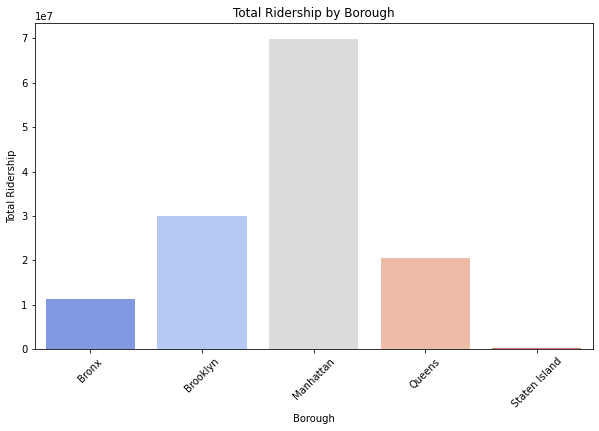

In [26]:
plt.figure(figsize=(10, 6))
sns.barplot(x=ridership_sum.index, y=ridership_sum.values, palette='coolwarm')
plt.xlabel("Borough")
plt.ylabel("Total Ridership")
plt.title("Total Ridership by Borough")
plt.xticks(rotation=45)  # Rotate labels for better readability
plt.show()

In [27]:
aggs_rules = {
    'transit_timestamp': 'first',
    'borough': 'first',
    'payment_method': 'first',
    'fare_class_category': 'first',
    'ridership': 'sum',
    'transfers': 'first',
    'latitude': 'first',
    'longitude': 'first',
    'station_complex_id':'first',
    'rain_status': lambda x: x.mode().iloc[0] if not x.mode().empty else None,  # Use most common value
}
 
# Perform aggregation
Weather_combined = Daily_ride_with_rainstatus.groupby(['transit_timestamp', 'station_complex_id']).agg(aggs_rules)
 
# Drop any extra transit_timestamp column, if exists, after aggregation
Weather_combined = Weather_combined.loc[:, ~Weather_combined.columns.duplicated()]
 
# Display the relevant columns
print(Weather_combined[['transit_timestamp', 'station_complex_id', 'rain_status']].head())

                                     transit_timestamp station_complex_id  \
transit_timestamp station_complex_id                                        
2020-08-11        201                       2020-08-11                201   
2021-09-17        1                         2021-09-17                  1   
                  10                        2021-09-17                 10   
                  100                       2021-09-17                100   
                  101                       2021-09-17                101   

                                     rain_status  
transit_timestamp station_complex_id              
2020-08-11        201                      Rainy  
2021-09-17        1                        Rainy  
                  10                       Rainy  
                  100                      Rainy  
                  101                      Rainy  


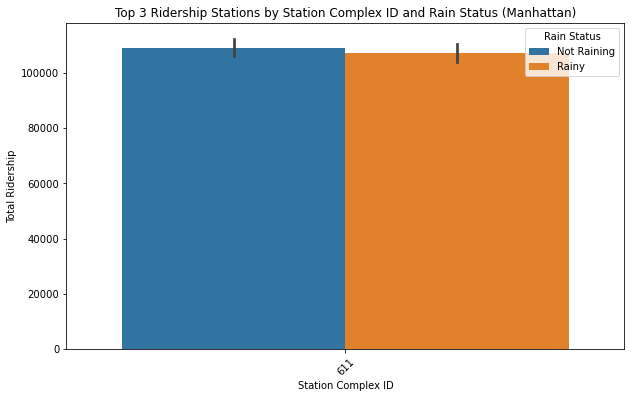

In [28]:

# Filter for Manhattan stations
filtered_data = Weather_combined[Weather_combined['borough'] == 'Manhattan']

# Select the top 20 stations by ridership
top_3_stations = filtered_data.nlargest(30, 'ridership')

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(
    data=top_3_stations, 
    x='station_complex_id', 
    y='ridership', 
    hue='rain_status'
)

plt.xlabel("Station Complex ID")
plt.ylabel("Total Ridership")
plt.title("Top 3 Ridership Stations by Station Complex ID and Rain Status (Manhattan)")
plt.legend(title="Rain Status")
plt.xticks(rotation=45)
plt.show()


In [29]:
"""In this analysis, we use a bar chart to compare the average subway ridership across different boroughs. 
Additionally, we examine the total ridership by borough to gain a more comprehensive understanding of ridership distribution.

The results indicate that Manhattan has the highest ridership, likely due to its role as the business hub of 
New York City and its extensive subway network. Given this, the MTA may consider allocating more funds to Manhattan,
as it has the largest transit network and generates the highest revenue based on average daily ridership. 
Conversely, Staten Island exhibits significantly lower subway connectivity compared to the other boroughs, 
highlighting a disparity in transit accessibility.
"""


'In this analysis, we use a bar chart to compare the average subway ridership across different boroughs. \nAdditionally, we examine the total ridership by borough to gain a more comprehensive understanding of ridership distribution.\n\nThe results indicate that Manhattan has the highest ridership, likely due to its role as the business hub of \nNew York City and its extensive subway network. Given this, the MTA may consider allocating more funds to Manhattan,\nas it has the largest transit network and generates the highest revenue based on average daily ridership. \nConversely, Staten Island exhibits significantly lower subway connectivity compared to the other boroughs, \nhighlighting a disparity in transit accessibility.\n'

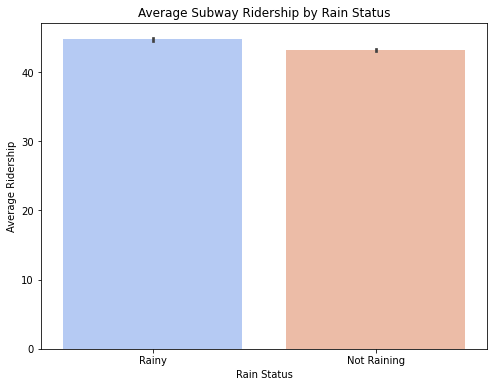

In [30]:
###now we are going to analysis Ridership by rain status

plt.figure(figsize=(8,6))
sns.barplot(x='rain_status', y='ridership', data=Daily_ride_with_rainstatus, palette='coolwarm', estimator=np.mean)
plt.xlabel("Rain Status")
plt.ylabel("Average Ridership")
plt.title("Average Subway Ridership by Rain Status")
plt.show()


In [31]:
"""This Analysis show that there is a increase in usage of subway However futher analysis has to be done to see if it is a signifact factor to ridership behavior"""

'This Analysis show that there is a increase in usage of subway '

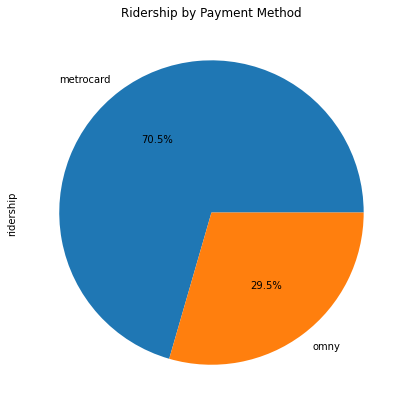

In [32]:
##now we are going to see what payment method had the highest ridership.

payment_ridership = Daily_ride_with_rainstatus.groupby('payment_method')['ridership'].sum()

payment_ridership.plot(kind='pie', figsize=(7, 7), autopct='%1.1f%%', legend=False)
plt.title('Ridership by Payment Method')
plt.show()


In [33]:
"""This pie chart illustrates that a majority of riders use the OMNY payment method, 
which allows for tap-to-pay via phone. This insight can help the MTA strategically target 
its advertising efforts and promote monthly or yearly passes to maximize adoption and revenue."""


'This pie chart illustrates that a majority of riders use the OMNY payment method, \nwhich allows for tap-to-pay via phone. This insight can help the MTA strategically target \nits advertising efforts and promote monthly or yearly passes to maximize adoption and revenue.'

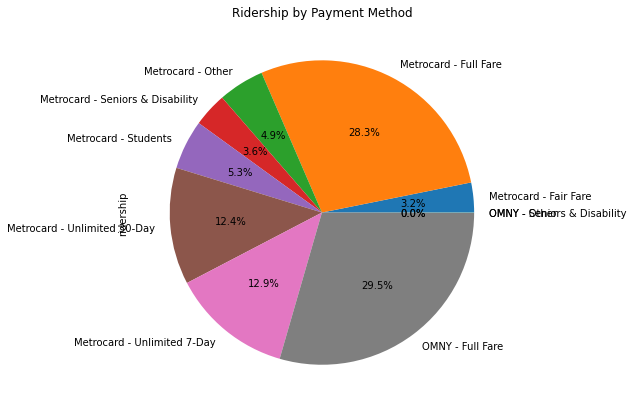

In [53]:
payment_ridership = Daily_ride_with_rainstatus.groupby('fare_class_category')['ridership'].sum()

payment_ridership.plot(kind='pie', figsize=(7, 7), autopct='%1.1f%%', legend=False)
plt.title('Ridership by Payment Method')
plt.show()

In [35]:
###We are going to do Logistic Regresion 
#first we have to convert the 'rain_status column to binary'

Daily_ride_with_rainstatus['rain_status_categorical']=Daily_ride_with_rainstatus['rain_status'].map({'Rainy':1,'Not Raining':0})

In [36]:
Daily_ride_with_rainstatus.head(1)

,transit_timestamp,station_complex_id,station_complex,borough,payment_method,fare_class_category,ridership,transfers,latitude,longitude,rain_status,rain_status_categorical
0,2022-05-16,617,"Atlantic Av-Barclays Ctr (B,D,N,Q,R,2,3,4,5)",Brooklyn,metrocard,Metrocard - Full Fare,239.0,3.0,40.68446,-73.97689,Rainy,1


In [37]:
# Convert 'ridership' to numeric and classify as high (1) or low (0) based on the median
Daily_ride_with_rainstatus['ridership']=pd.to_numeric(Daily_ride_with_rainstatus['ridership'], errors='coerce')

In [38]:
##We need to define a high and low ridership mean to turn the ridership into catergorical
##here we defined median_ridership using the median ridership from the Dataframe

median_ridership = Daily_ride_with_rainstatus['ridership'].median()

In [39]:
##this median approach creats a natural split point

Daily_ride_with_rainstatus['high_ridership'] = (Daily_ride_with_rainstatus['ridership'] >= median_ridership).astype(int)


In [40]:
##Drop mssing values

Daily_ride_with_rainstatus =Daily_ride_with_rainstatus.dropna(subset=['rain_status','high_ridership'])

In [41]:
X = Daily_ride_with_rainstatus[["rain_status_categorical"]]
y = Daily_ride_with_rainstatus["high_ridership"]

In [42]:
##Now we split the data into traiining and testing set (using 60-40split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [43]:
#now e are training the logistic regression
model = LogisticRegression()
model.fit(X_train,y_train)

LogisticRegression()

In [44]:
##We thest our model using the test data
y_pred =model.predict(X_test)

In [45]:
# Evaluate model performance
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [46]:
print(f"Accuracy: {accuracy:.4f}")
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)

Accuracy: 0.5156
Confusion Matrix:
 [[     0 290647]
 [     0 309353]]
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00    290647
           1       0.52      1.00      0.68    309353

    accuracy                           0.52    600000
   macro avg       0.26      0.50      0.34    600000
weighted avg       0.27      0.52      0.35    600000



In [47]:
"""
Based on the Accuracy being 50% which is low , we can say the model correctly predicts 
high\/low ridership about half the time.

##From the confusion Matrix:
Model predicts False Postitives: high ridership but actual was low (253954)and false Negatives: 

Because of limited time we were unable to make the accuracy higher by using feature engineering :
by adding other data factors
"""

'\nBased on the Accuracy being 50% which is low , we can say the model correctly predicts \nhigh\\/low ridership about half the time.\n\n##From the confusion Matrix:\nModel predicts False Postitives: high ridership but actual was low (253954)and false Negatives: \n\nBecause of limited time we were unable to make the accuracy higher by using feature engineering :\nby adding other data factors\n'

In [48]:
import folium
 
# New York City center coordinates
nyc_coordinates = [40.7128, -74.0060]
 
# Create a map centered on NYC
m = folium.Map(location=nyc_coordinates, zoom_start=12)
 
locations = [
    {"name": "Cortlandt Park-242st", "coords": [40.889248, -73.898583]},
    {"name": "238 ST", "coords": [40.884667, -73.90087]},
    {"name": "231 ST", "coords": [40.878856, -73.904834]},
    {"name": "Marble Hill-225 St", "coords": [40.874561, -73.909831]},
    {"name": "215 ST", "coords": [40.869444, -73.915279]},
    {"name": "207 ST", "coords": [40.864621, -73.918822]},
    {"name": "Dyckman St", "coords": [40.860531, -73.925536]},
    {"name": "191 ST", "coords": [40.855225, -73.929412]},
    {"name": "181 ST", "coords": [40.849505, -73.933596]},
    {"name": "168 St-Washington Hts", "coords": [40.840556, -73.940133]},
    {"name": "157 St", "coords": [40.834041, -73.94489]},
    {"name": "42 St", "coords": [40.75731, -73.986755]},
    {"name": "Lincoln Center", "coords": [40.77344, -73.98221]},
    {"name": "Essex St", "coords": [40.718315, -73.987434]},
    {"name": "Penn Station", "coords": [40.750374, -73.99106]},
    {"name": "207 St", "coords": [40.86462, -73.91882]},
    {"name": "Rector St", "coords": [40.70722, -74.01334]},
    {"name": "18 St", "coords": [40.74104, -73.99787]},
    {"name": "Natural History", "coords": [40.781433, -73.972145]}
]
 
for loc in locations:
    folium.Marker(location=loc["coords"], popup=loc["name"]).add_to(m)
m